# Data Processing Testing
This Jupyter notebook is intended for testing a data processing pipeline. The idea being to organize the functions in its own library. Helping with future testing.


NOTICE: I WANT MULTIPLICATION AND DIVISION OF IMPORTANT SIGNALS AS WELL!

In [3]:
# Data Processing Tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [4]:
train_a = pd.read_parquet('A/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')

## Pre Processing
Removing NaN values, and filling in important holes in the data.

In [5]:
X_train_estimated_a = X_train_estimated_a.drop("date_calc", axis = 1)

X = pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0, ignore_index=True)

X = X.interpolate(method='linear')
X = X.bfill()

## Time Dependency
The values that we have gotten usually don't have any direct time dependency. This is however wrong all parameters change over time, and the machine learning model having access to what has happened during the previous iteration may be helpfull. This part is only intended to work with time series, and aims to add features such as integrals and derivatives.

Main concepts being
- Derivative estimates
- Double derivative estimates
- Integral effect estimates
- Double integral estimates


In [6]:
def add_derivative_to_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """

    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    for measurement in measurements:
        # Calculate derivative estimates
        df['derivative_' + measurement] = df[measurement].diff() / df['time_diff'].dt.total_seconds()
    
    df = df.drop('time_diff', axis =  1)

    # Since the first element will result in a NaN, we must backfill this one.
    df = df.interpolate(method='linear')
    df = df.bfill()
    
    return df

def add_double_derivative_to_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """

    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    # Calculate derivative estimates
    for measurement in measurements:
        df['derivative_' + measurement] = df[measurement].diff() / (df['time_diff'].dt.total_seconds()**2)
    
    df = df.drop('time_diff', axis=1)
    
    # Since the first element will result in a NaN, we must backfill this one.
    df = df.interpolate(method='linear')
    df = df.fillna(method="backfill", axis=None)

    return df

def add_double_integral_to_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps)

    # Create a new column for the date
    df['date'] = df[timeStamps].dt.date

    for measurement in measurements:
        # Calculate the integral value for each day
        df['integral_' + measurement] = df.groupby('date')[measurement].cumsum()**2
    
    df = df.drop('date', axis=1)

    return df



In [7]:
# Testing the functions.

# Should make a dummy test set :)
timestamps = "date_forecast"

measurements = list(X.columns.values)
measurements.remove(timestamps)


X_with_derivatives = add_derivative_to_df(X, timestamps, measurements)

print("absolute_humidity_2m:gm3 ")
print(X_with_derivatives["absolute_humidity_2m:gm3"].head())
print("Derivative absolute_humidity_2m:gm3 ")
print(X_with_derivatives["derivative_absolute_humidity_2m:gm3"].head())

# Should add some tests in the spirit of Sverre

# Counting NaN values in all columns
nan_count = X_with_derivatives.isna().sum()
print("Nan values: ", sum(nan_count.values))

X_with_double_derivatives = add_double_derivative_to_df(X, timestamps, measurements)
print(X_with_double_derivatives.head())
nan_count = X_with_double_derivatives.isna().sum()
print("Nan values: ", sum(nan_count.values))

# X_with_integrals = add_integral_to_df(X, timestamps, measurements)
# print(X_with_integrals.head())
# nan_count = X_with_integrals.isna().sum()
# print("Nan values: ", sum(nan_count.values))
# print(X_with_integrals[timestamps][96:120])
# print(X_with_integrals["integral_absolute_humidity_2m:gm3"][96:120])
# # Just return integrals and derivatives!

# X_with_double_integrals = add_integral_to_df(X, timestamps, measurements)
# print(X_with_integrals.head())
# nan_count = X_with_integrals.isna().sum()
# print("Nan values: ", sum(nan_count.values))
# print(X_with_integrals[timestamps][96:120])
# print(X_with_integrals["integral_absolute_humidity_2m:gm3"][96:120])
# # Just return integrals and derivatives!

absolute_humidity_2m:gm3 
0    7.7
1    7.7
2    7.7
3    7.7
4    7.7
Name: absolute_humidity_2m:gm3, dtype: float32
Derivative absolute_humidity_2m:gm3 
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: derivative_absolute_humidity_2m:gm3, dtype: float64
Nan values:  0


C:\Users\isakasa\AppData\Local\Temp\ipykernel_15424\160218328.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="backfill", axis=None)


        date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-06-02 22:00:00                       7.7                1.230   
1 2019-06-02 22:15:00                       7.7                1.229   
2 2019-06-02 22:30:00                       7.7                1.228   
3 2019-06-02 22:45:00                       7.7                1.226   
4 2019-06-02 23:00:00                       7.7                1.225   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1744.900024                    0.0              0.0   
1           1734.000000                    0.0              0.0   
2           1723.500000                    0.0              0.0   
3           1713.400024                    0.0              0.0   
4           1703.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1744.900024              0.0      280.299988            0.0  ...   
1       1734

## Spliting Date Time Data
The dateTime values are helpfull only so far as doing splitting, and aligning each timestamp. Other than this their usefullness is not that great. Instead we will attempt to split them into a set of values.

Such as:
- Hour
- Date
- Month
- Year

In [8]:
def extracting_time_data(df: pd.DataFrame, timestamps: str) -> pd.DataFrame: 
    # Extracting components
    df['day_of_year'] = df[timestamps].dt.dayofyear
    df['month'] = df[timestamps].dt.month
    df['year'] = df[timestamps].dt.year
    df['hour'] = df[timestamps].dt.hour
    
    return df

In [9]:
# Testing time data splitter
X = extracting_time_data(X, timestamps)


## Matching X and y
The last steps finding the values that are the corresponding to our measurements.

In [10]:

def data_length_matching(train: pd.DataFrame, obs: pd.DataFrame)-> tuple[pd.DataFrame, pd.DataFrame]:
    """
    This function is intended to ensure that both the training data and
    the observed data are sorted, and contain the same number of entries. 
    """

    # Cut the data frames so that their date match.
    obs_feature_test = obs[obs['date_forecast'].isin(train['time'])].sort_values(by=['date_forecast'])  # sortert etter datao
    # If only one of them has the date ensure that the other also has the same sorting.
    train_feature_test = train[train['time'].isin(obs['date_forecast'])].sort_values(by=['time'])       # sortert etter datao

    return train_feature_test, obs_feature_test


# No need to train on bad values.
y = train_a.dropna()

# Removing rows that have no matching value, but this is however not that important. The last step before feeding into machine learning algorithm.
y, X = data_length_matching(y, X)

# Resetting the indexes
y = y.reset_index(drop = True)
X = X.reset_index(drop = True)

## Frequency Combinations And Filtering
It might be so that several feature are either poorly sampled, or the read data from the sensor experiences noise. Having the ability to convelute features as well as filtering out unwanted frequencies may be a huge gain for the features performance. This part is intended to test and create a set of functionalities that helps us using frequency analysis in addition to what we already know.

In [11]:

def n_largest_filter(df: pd.DataFrame, measurements: list[str],n_largest: int):
    """
    Generates values based on the largest frequencies that are present.
    """
    for measurement in measurements:
        signal = df[measurement].values

        fft_result = np.fft.fft(signal)
        
        # Keep only the dominant frequencies (e.g., top 5)
        num_components_to_keep = n_largest

        indices = np.argsort(np.abs(fft_result))[::-1][:num_components_to_keep]

        # Set all other frequency components to zero
        fft_result_filtered = np.zeros_like(fft_result)
        fft_result_filtered[indices] = fft_result[indices]

        # Compute IFFT
        ifft_result = np.fft.ifft(fft_result_filtered)

        # Add the filtered results to the dataframe
        df["filtered_" + measurement] = ifft_result.real

    return df

def frequency_combination(df: pd.DataFrame, features: list[str]) -> np.array:
    """
    Takes the fourier transform of multiple signals add them together, and then takes the inverse.

    features: Are what you would like to combine.
    df: Chosen dataframe containing feature information.
    """

    total_fft = 0
    
    for feat in features:
        # Finding the signal directly might be wrong due to timestamps and such, but might still be helpful. It is not correct, but improvements like day by day sampling might be useful.
        signal = df[feat].values

        # Min-max scaling
        scaled_signal = min_max_scale_signal(signal)
        
        fft = np.fft.fft(scaled_signal)
        total_fft = total_fft + fft
    
    ifft_result = np.fft.ifft(total_fft)

    return ifft_result.real

def min_max_scale_signal(signal: np.array) -> np.array:
    # Calculate min and max values
    min_val = np.min(signal)
    max_val = np.max(signal)

    # Min-max scaling
    scaled_signal = (signal - min_val) / (max_val - min_val)

    return scaled_signal


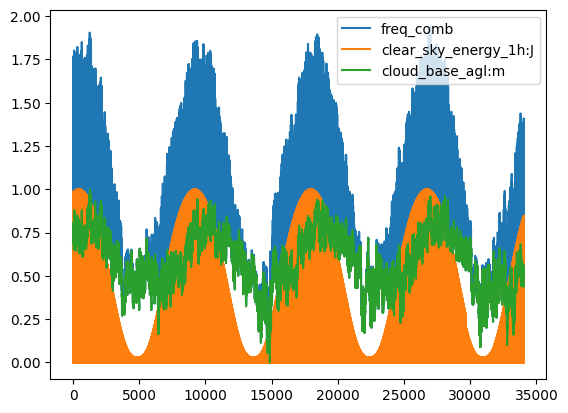

In [12]:

# Testing The Above Functions
X_n_largest_filter =  n_largest_filter(X, measurements, 12)

# Notice that all features should probably be scaled the same :/

features = ["clear_sky_energy_1h:J", "dew_point_2m:K"]
freq_comb = frequency_combination(X, features)

x_vals = list(range(len(X.index)))

sig_0 = min_max_scale_signal(X[features[0]].values)

sig_1 = min_max_scale_signal(X[features[1]].values)

plt.plot(x_vals, freq_comb, label="freq_comb")
plt.plot(x_vals, sig_0, label="clear_sky_energy_1h:J")
plt.plot(x_vals, sig_1, label="cloud_base_agl:m")

plt.legend()

# Show the plot
plt.show()




## Feedback
Notice that we do have previous to the values of the events that have happened. So adding the timesteps for the day that happened into the system might help.

In [14]:
y = train_a
import feature_generation as fg

y_shifted_24h = fg.shifted_values_24_h(y, "pv_measurement")

print(y_shifted_24h[0:25])





        n-1      n-2      n-3      n-4      n-5      n-6      n-7      n-8  \
0       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      0.00      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      0.00     0.00      NaN      NaN      NaN      NaN      NaN      NaN   
3      0.00     0.00     0.00      NaN      NaN      NaN      NaN      NaN   
4      0.00     0.00     0.00     0.00      NaN      NaN      NaN      NaN   
5     19.36     0.00     0.00     0.00     0.00      NaN      NaN      NaN   
6    251.02    19.36     0.00     0.00     0.00     0.00      NaN      NaN   
7    263.78   251.02    19.36     0.00     0.00     0.00     0.00      NaN   
8    522.72   263.78   251.02    19.36     0.00     0.00     0.00     0.00   
9    904.42   522.72   263.78   251.02    19.36     0.00     0.00     0.00   
10  1238.82   904.42   522.72   263.78   251.02    19.36     0.00     0.00   
11  2189.88  1238.82   904.42   522.72   263.78   251.02    19.3